# Importation des librairies

In [36]:
import pandas as pd
import numpy as np
import requests
import cartiflette.s3 as s3
import geopandas as gpd
from shapely.geometry import shape
from io import StringIO
from sklearn.impute import KNNImputer

# Importation des bases

## Import des bases de données via API de l'OpenDataSoft

L'éxécution de la requête API prend assez de temps

In [2]:
def get_data_ODS(dataset_name):
    """
    Fonction qui permet de récupérer des données via l'API d'OpenDataSoft
    Elle retourne un dataframe
    
    """
    df = pd.DataFrame()
    # URL de base pour accéder à l'API d'ODS
    base_url_ODS = "https://odre.opendatasoft.com/api/explore/v2.1"
    
    dataset_path = f"/catalog/datasets/{dataset_name}/exports/json?lang=fr&timezone=Europe%2FBerlin"
    url = f"{base_url_ODS}{dataset_path}"
    
    # Exécution de la requête GET
    
    response = requests.get(url)
    # Vérification si la requête a réussi
    if response.status_code == 200:
        # Extraction des données
        data = response.json()
        # Conversion des résultats en DataFrame
        df = pd.DataFrame(data)
    else:
        print(f"Erreur lors de la requête: {response.status_code}")

    return df


def get_data_ODSW(dataset_name, output = "json"):
    """
    Fonction qui permet de récupérer des données via l'API  publique d'OpenDataSoft
    Elle retourne un dataframe
    
    """
    df = pd.DataFrame()
    # URL de base pour accéder à l'API d'ODS
    base_url_ODS = "https://public.opendatasoft.com/api/explore/v2.1"
    
    dataset_path = f"/catalog/datasets/{dataset_name}/exports/{output}?lang=fr&timezone=Europe%2FBerlin"
    url = f"{base_url_ODS}{dataset_path}"
    
    # Exécution de la requête GET
    response = requests.get(url)
    # Vérification si la requête a réussi
    if response.status_code == 200:
        # Extraction des données
        if output == "json":
            data = response.json()
            # Conversion des résultats en DataFrame
            df = pd.DataFrame(data)
        else:
            data = response.json()
            geometries = [shape(feature['geometry']) for feature in data['features']]
            properties = [feature['properties'] for feature in data['features']]
    
            # Créer un GeoDataFrame en combinant les géométries et les propriétés
            df = gpd.GeoDataFrame(geometry=geometries, data=properties)
    else:
        print(f"Erreur lors de la requête: {response.status_code}")

    return df

In [4]:
consumption_dataset_name = "consommation-quotidienne-brute-regionale"
weather_dataset_name = "donnees-synop-essentielles-omm"
#geographic_dataset_name = "georef-france-commune"
holiday_dataset_name = "jours-ouvres-week-end-feries-france-2010-a-2030"
data_consumption = get_data_ODS(consumption_dataset_name)
data_weather = get_data_ODSW(weather_dataset_name)
#data_geo = get_data_ODSW(geographic_dataset_name, output="geojson")
holiday_dataset = get_data_ODSW(holiday_dataset_name)

On traite les colonnes du dataset geographique pour enregistrer les données sous format GeoJson

In [31]:
#On recupère les colonnes importantes de la base de données
#geo_cols = ['geo_point_2d', 'year', 'reg_code', 'reg_name', 'dep_code', 'dep_name','geometry']
#data_geo = data_geo[geo_cols]
#treated_geo_cols = ['year', 'reg_code', 'reg_name', 'dep_code', 'dep_name']
##On effectue un nettoyage des données contenues dans les colonnes
#data_geo[treated_geo_cols] = data_geo[treated_geo_cols].applymap(lambda x: x.replace('[', '').replace(']', '') if isinstance(x, str) else x)
#data_geo[treated_geo_cols] = data_geo[treated_geo_cols].applymap(lambda x: ''.join(filter(lambda char: char.isalnum() or char in ['_', '-', '@', '#'], str(x))))

,geo_point_2d,year,reg_code,reg_name,dep_code,dep_name,geometry
0,"{'lon': 4.186473859960533, 'lat': 48.520816933...",2023,44,GrandEst,10,Aube,"POLYGON ((4.18730 48.54392, 4.18724 48.54250, ..."
1,"{'lon': 4.598596436015939, 'lat': 48.306537350...",2023,44,GrandEst,10,Aube,"POLYGON ((4.62567 48.32423, 4.62429 48.32356, ..."
2,"{'lon': 4.6153344590215, 'lat': 48.44294278327...",2023,44,GrandEst,10,Aube,"POLYGON ((4.63562 48.45660, 4.63535 48.45667, ..."
3,"{'lon': 3.8349133102621433, 'lat': 48.10864367...",2023,44,GrandEst,10,Aube,"POLYGON ((3.80166 48.10673, 3.80124 48.10597, ..."
4,"{'lon': 1.8228167609346886, 'lat': 43.33065948...",2023,76,Occitanie,11,Aude,"POLYGON ((1.83985 43.32973, 1.83966 43.32982, ..."


## Import d'une base de données complémentaire (celle des régions, communes, et départements de France

Cette importation va se faire à travers une requête via l'API de Datagouv

In [3]:
#Identifiant du dataset
dataset_id = "4a7c837bb6da8e363604082bcc8b2e504cf08038"
dataset_sha1 = "dbe8a621-a9c4-4bc3-9cae-be1699c5ff25"

# URL de base pour accéder à l'API
base_url = "https://www.data.gouv.fr/api/1/"

# Chemin pour accéder aux enregistrements du dataset
dataset_path = f"datasets/r/{dataset_sha1}?dataset={dataset_id}"

# Construction de l'URL complète
url = f"{base_url}{dataset_path}"

# Exécution de la requête GET
response = requests.get(url)

# Vérification si la requête a réussi
if response.status_code == 200:
    # Lecture du contenu CSV
    data_communes = pd.read_csv(StringIO(response.content.decode('utf-8')))
else:
    print(f"Erreur lors de la requête: {response.status_code}")

On enregistre la base pour ne plus avoir à éxécuter la requête API à chaque étape

In [6]:
data_consumption.to_csv('data_consumption.csv', index=False)
data_communes.to_csv('data_communes.csv', index=False)
data_weather.to_csv('data_weather.csv', index = False)
#data_geo.to_file("data_geo.geojson", driver='GeoJSON')

In [4]:
data_consumption = pd.read_csv('data_consumption.csv')
data_communes = pd.read_csv('data_communes.csv')
data_weather = pd.read_csv('data_weather.csv')
#data_geo = gpd.read_file("data_geo.geojson")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [37]:
dep = s3.download_vectorfile_url_all(
    values = "metropole",
    crs = 4326,
    borders = "DEPARTEMENT",
    vectorfile_format="topojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=DEPARTEMENT/crs=4326/FRANCE_ENTIERE=metropole/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 7.17MiB [00:00, 93.6MiB/s]


Les dataframes de consommation et météorologiques  étant sous forme de séries temporelles, on place les dates en index.

In [5]:
data_consumption['date'] = pd.to_datetime(data_consumption['date'])
data_consumption.set_index('date', inplace=True)

In [6]:
data_consumption.head()

,date_heure,heure,code_insee_region,region,consommation_brute_gaz_grtgaz,statut_grtgaz,consommation_brute_gaz_terega,statut_terega,consommation_brute_gaz_totale,consommation_brute_electricite_rte,statut_rte,consommation_brute_totale
date,,,,,,,,,,,,
2019-02-01,2019-02-01T06:00:00+01:00,06:00,27,Bourgogne-Franche-Comté,5053.0,Définitif,NaN,NaN,5053.0,3052,Définitif,8105.0
2019-02-01,2019-02-01T07:00:00+01:00,07:00,24,Centre-Val de Loire,4079.0,Définitif,NaN,NaN,4079.0,3117,Définitif,7196.0
2019-02-01,2019-02-01T07:00:00+01:00,07:00,52,Pays de la Loire,5795.0,Définitif,NaN,NaN,5795.0,4646,Définitif,10441.0
2019-02-01,2019-02-01T07:30:00+01:00,07:30,24,Centre-Val de Loire,NaN,NaN,NaN,NaN,NaN,3252,Définitif,NaN
2019-02-01,2019-02-01T07:30:00+01:00,07:30,28,Normandie,NaN,NaN,NaN,NaN,NaN,4911,Définitif,NaN


Choix de l'année

In [7]:
annee_choisie = 2022
data_consumption = data_consumption[data_consumption.index.year == annee_choisie]


In [144]:
data_communes[['code_commune_INSEE', 'code_commune']]

,code_commune_INSEE,code_commune
0,1001,1.0
1,1002,2.0
2,1004,4.0
3,1005,5.0
4,1006,6.0
...,...,...
39196,98831,831.0
39197,98832,832.0
39198,98833,833.0
39199,98901,901.0


In [9]:
col_del = pd.Index(['date_heure', 'consommation_brute_gaz_grtgaz', 'statut_grtgaz', 'consommation_brute_gaz_terega', 'statut_terega','consommation_brute_gaz_totale','statut_rte', 'consommation_brute_totale'])
data_consumption.drop(col_del, axis=1,inplace=True)
data_consumption.isna().sum()

heure                                 0
code_insee_region                     0
region                                0
consommation_brute_electricite_rte    0
dtype: int64

## Aggrégation des consommations par date et par région

In [10]:
data_consumption1 = data_consumption.groupby(['code_insee_region','date'], as_index = False)
data_consumption2 = data_consumption.groupby(['code_insee_region','date','heure'], as_index = False)

In [11]:
data_consumption1 = data_consumption1['consommation_brute_electricite_rte'].sum()
data_consumption2 = data_consumption2['consommation_brute_electricite_rte'].sum()

In [12]:
data_consumption1.head()

,code_insee_region,consommation_brute_electricite_rte
0,11,345462
1,11,356965
2,11,414973
3,11,429347
4,11,484779


### Calcul des superficies par département

### Calcul de la superficie

In [38]:
## On divise par par 1e6 pour obtenir la superficie par commune en km²
#data_geo['superficie_comm'] = data_geo['geometry'].area / 1e6  
#
##On fait un regroupement par département, et on calcule la superficie par département en sommant les autres superficies
#data_geo['superficie_dep'] = data_geo.groupby('dep_code')['superficie_comm'].transform('sum')
dep["superficie"] = dep.to_crs(2154).area

### Traitement de la base weather

In [14]:
nouveaux_noms_colonnes={'numer_sta':'num_station', 'date':'date_UTC', 'pmer':'pression_mer', 'tend':'variation_pression_3h', 'cod_tend':'type_tendance_baro', 'dd':'direction_vent', 'ff':'vitesse_vent', 't':'temperature', 'td':'point_de_rosee',
       'u':'humidite', 'vv':'visibilite_horizontale', 'ww':'temps_present', 'w1':'temps_passe_1', 'w2':'temps_passe_2', 'n':'nebulosite_totale', 'nbas':'nebulosite_nuage_etage_inf', 'hbas':'hauteur_base_nuage_etage_inf', 'cl':'type_nuage_etage_inf', 'cm':'type_nuage_etage_moyen', 'ch':'type_nuage_etage_sup',
       'pres':'pression_station', 'niv_bar':'niveau_barometriq', 'geop':'geopotentiel', 'tend24':'variation_pression_24h', 'tn12':'temperature_min_sur_12h', 'tn24':'temperature_min_sur_24h', 'tx12':'temperature_max_sur_12h', 'tx24':'temperature_max_sur_24h',
       'tminsol':'temperature_min_sol_sur_12h', 'sw':'methode_mesure_temperature_thermometre_mouille', 'tw':'temperature_thermometre_mouille', 'raf10':'rafales_10_dernieres_minutes', 'rafper':'rafales_sur_une_periode', 'per':'periode_mesure_rafales', 'etat_sol':'etat_du_sol', 'ht_neige':'hauteur_totale_couche_neige/glace_au_sol',
       'ssfrai':'hauteur_neige_fraiche', 'perssfrai':'periode_mesure_neige_fraiche', 'rr1':'precipitation_dans_1_derniere_heure', 'rr3':'precipitation_dans_3_derniere_heure', 'rr6':'precipitation_dans_6_derniere_heure', 'rr12':'precipitation_dans_12_derniere_heure', 'rr24':'precipitation_dans_24_derniere_heure', 'phenspe1':'phenomene_special_1',
       'phenspe2':'phenomene_special_2', 'phenspe3':'phenomene_special_3', 'phenspe4':'phenomene_special_4', 'nnuage1':'nebulosite_couche_nuageuse_1', 'ctype1':'type_de_nuage_1', 'hnuage1':'hauteur_de_base_nuage_1',
       'nnuage2':'nebulosite_couche_nuageuse_2', 'ctype2':'type_de_nuage_2', 'hnuage2':'hauteur_de_base_nuage_2', 'nnuage3':'nebulosite_couche_nuageuse_3', 'ctype3':'type_de_nuage_3', 'hnuage3':'hauteur_de_base_nuage_3',
       'nnuage4':'nebulosite_couche_nuageuse_4', 'ctype4':'type_de_nuage_4', 'hnuage4':'hauteur_de_base_nuage_4', 'coordonnees':'coordonnees', 'nom':'nom_commune',
       'type_de_tendance_barometrique':'type_de_tendance_barometrique', 'temps_passe_1':'temps_passe_1', 'temps_present':'temps_present', 'tc':'temperature_degre_celcius',
       'tn12c':'temperature_celcius_min_sur_12h', 'tn24c':'temperature_celcius_min_sur_24h', 'tx12c':'temperature_celcius_max_sur_12h', 'tx24c':'temperature_celcius_max_sur_24h', 'tminsolc':'temperature_celcius_min_sol_sur_12h', 'latitude':'latitude', 'longitude':'longitude',
       'altitude':'altitude', 'libgeo':'libelle_geolocalisation', 'codegeo':'code_geolocalisation', 'nom_epci':'nom_EPCI', 'code_epci':'code_EPCI', 'nom_dept':'nom_departement',
       'code_dep':'code_departement', 'nom_reg':'nom_region', 'code_reg':'code_region', 'mois_de_l_annee':'mois'}

In [165]:
base_meteo_modifie_1 = data_weather.rename(columns=nouveaux_noms_colonnes)

## Identification des variables météoroliques à retenir

Il est question d'identifier les les variables météorologiques se reférant aux espects retenus Après une revue de la littérature:
* __Température :__ les variables identifiées sont la température en degré celcius ('temperature_degre_celcius'), la température minimale sur les 24 dernières heures ('temperature_celcius_min_sur_24h'), et la température maximale sur les 24 dernières heures ('temperature_celcius_max_sur_24h')
* __Vitesse du vent :__ la variable identifiée est la vitesse du vent ('vitesse_vent')
* __Couverture nuageuse :__ la variable identifié est la nébulosité totale et renvoie à la quantité totale de nuages couvrant le ciel ou plus simplement le degré de couverture nuageuse dans le ciel ('nebulosite_totale')
* __Humidité :__ la variable identifiée est l'indice d'humidité ('humidite')
* __Rayonnement global :__ la variable identifiée pour capter cet aspect est la distance maximale à laquelle des objets peuvent être clairement discernés à l'horizon ('visibilite_horizontale')

In [138]:
base_meteo_modifie_1['latitude'].nunique()

62

In [139]:
data_communes['latitude'].nunique()

35921

In [150]:
weather_vars = ['num_station', 'date_UTC', 'vitesse_vent', 'temperature','nebulosite_totale','temperature_degre_celcius', 'temperature_celcius_min_sur_24h', 'temperature_celcius_max_sur_24h','latitude', 'longitude','altitude', 'libelle_geolocalisation', 'code_geolocalisation','nom_departement', 'code_departement','nom_region', 'code_region', 'mois', 'visibilite_horizontale', 'coordonnees','nom_commune',]
base_meteo_modifie_1 = base_meteo_modifie_1[weather_vars]

### Vérification et gestion des valeurs manquantes pour les variables d'agrégation

#### Vérification des régions et départements manquants

In [59]:
print(base_meteo_modifie_1['nom_region'].isnull().sum())
print(base_meteo_modifie_1['code_region'].isnull().sum())
print(base_meteo_modifie_1['nom_departement'].isnull().sum())
print(base_meteo_modifie_1['code_departement'].isnull().sum())
print(base_meteo_modifie_1['nom_commune'].isnull().sum())

242657
242657
242657
242657
0


On constate que tous les noms de commune sont renseignés, mais certains noms de région et département ne le sont pas. Nous allons donc utiliser les noms de commune pour renseigner les départements et régions manquants.

Nous explorons la possibilité de completer les régions et départements manquants à partir de la base de données des communes, régions et départements.

In [124]:
data_communes.isna().sum()

code_commune_INSEE          0
nom_commune_postal          0
code_postal                 0
libelle_acheminement        0
ligne_5                 35944
latitude                  269
longitude                 269
code_commune                0
article                 36621
nom_commune                 0
nom_commune_complet         0
code_departement            0
nom_departement           267
code_region                 0
nom_region                267
dtype: int64

Le dataset des communes possède lui même des valeurs manquantes au niveau des codes de département et de région. Nous allons compléter ces valeurs manquantes en utilisant les combinaisons "code_commune - code_departement - code-region" les plus fréquentes. Puis nous allons le joindre avec le dataset de météo.

In [111]:
for cat_var in ['code_commune', 'code_departement', 'code_region']:
    mode_value = data_communes[cat_var].mode().iloc[0]  # Sélectionne la 1ère combinaison de cat_var qui apparait le plus
    data_communes[cat_var].fillna(mode_value, inplace=True) 
data_local_join = data_communes['code_commune', 'code_departement', 'code_region']

Index(['code_commune_INSEE', 'nom_commune_postal', 'code_postal',
       'libelle_acheminement', 'ligne_5', 'latitude', 'longitude',
       'code_commune', 'article', 'nom_commune', 'nom_commune_complet',
       'code_departement', 'nom_departement', 'code_region', 'nom_region'],
      dtype='object')

In [166]:
len(base_meteo_modifie_1.columns)

82

In [215]:
i =0
for elt in l:
    if type(elt) != dict:
        i +=1
        l.append(ast.literal_eval(elt))

In [212]:
import ast

In [214]:
type(l[0])

dict

In [217]:
base_meteo_modifie_1['coordonnees'] = ast.literal_eval(base_meteo_modifie_1['coordonnees'])

ValueError: malformed node or string: 0                {'lon': 3.0195, 'lat': 44.1185}
1          {'lon': 54.520667, 'lat': -15.887667}
2               {'lon': -0.456167, 'lat': 49.18}
3              {'lon': -4.412, 'lat': 48.444167}
4            {'lon': 6.502333, 'lat': 44.565667}
                           ...                  
2353663         {'lon': 5.216, 'lat': 43.437667}
2353664        {'lon': 0.727333, 'lat': 47.4445}
2353665    {'lon': 54.520667, 'lat': -15.887667}
2353666        {'lon': 0.727333, 'lat': 47.4445}
2353667     {'lon': -0.500167, 'lat': 43.909833}
Name: coordonnees, Length: 2353668, dtype: object

In [216]:
json_normalize(ast.literal_eval(base_meteo_modifie_1['coordonnees']))

ValueError: malformed node or string: 0                {'lon': 3.0195, 'lat': 44.1185}
1          {'lon': 54.520667, 'lat': -15.887667}
2               {'lon': -0.456167, 'lat': 49.18}
3              {'lon': -4.412, 'lat': 48.444167}
4            {'lon': 6.502333, 'lat': 44.565667}
                           ...                  
2353663         {'lon': 5.216, 'lat': 43.437667}
2353664        {'lon': 0.727333, 'lat': 47.4445}
2353665    {'lon': 54.520667, 'lat': -15.887667}
2353666        {'lon': 0.727333, 'lat': 47.4445}
2353667     {'lon': -0.500167, 'lat': 43.909833}
Name: coordonnees, Length: 2353668, dtype: object

In [182]:
data = {'coordonnees': list(base_meteo_modifie_1['coordonnees'])}
df = pd.DataFrame(data)
df_normalized = json_normalize(df['coordonnees'])
df = pd.concat([df, df_normalized], axis=1)

# Supprimer la colonne d'origine contenant les dictionnaires
df = df.drop('coordonnees', axis=1)

# Afficher le DataFrame résultant
print(df)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[2353668 rows x 0 columns]


In [186]:
list(base_meteo_modifie_1['coordonnees'].as)

["{'lon': 3.0195, 'lat': 44.1185}",
 "{'lon': 54.520667, 'lat': -15.887667}",
 "{'lon': -0.456167, 'lat': 49.18}",
 "{'lon': -4.412, 'lat': 48.444167}",
 "{'lon': 6.502333, 'lat': 44.565667}",
 "{'lon': -56.179167, 'lat': 46.766333}",
 "{'lon': -60.995667, 'lat': 14.595333}",
 "{'lon': 3.0975, 'lat': 50.57}",
 "{'lon': 2.384333, 'lat': 48.716833}",
 "{'lon': -51.804667, 'lat': 3.890667}",
 "{'lon': 140.001, 'lat': -66.663167}",
 "{'lon': -1.939833, 'lat': 49.725167}",
 "{'lon': 8.792667, 'lat': 41.918}",
 "{'lon': -52.365333, 'lat': 4.822333}",
 "{'lon': 4.02, 'lat': 48.324667}",
 "{'lon': -0.500167, 'lat': 43.909833}",
 "{'lon': 5.216, 'lat': 43.437667}",
 "{'lon': -56.179167, 'lat': 46.766333}",
 "{'lon': 2.384333, 'lat': 48.716833}",
 "{'lon': 40.340667, 'lat': -22.344167}",
 "{'lon': 5.088333, 'lat': 47.267833}",
 "{'lon': 1.175, 'lat': 45.861167}",
 "{'lon': 54.520667, 'lat': -15.887667}",
 "{'lon': -1.939833, 'lat': 49.725167}",
 "{'lon': -3.473167, 'lat': 48.825833}",
 "{'lon': 

In [179]:
pip install --upgrade pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 23.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.2 requires pandas!=1.4.0,<2.1,>1.1, but you have pandas 2.1.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [178]:
base_meteo_modifie_1['coordonnees'].head(5)

0          {'lon': 3.0195, 'lat': 44.1185}
1    {'lon': 54.520667, 'lat': -15.887667}
2         {'lon': -0.456167, 'lat': 49.18}
3        {'lon': -4.412, 'lat': 48.444167}
4      {'lon': 6.502333, 'lat': 44.565667}
Name: coordonnees, dtype: object

## Agrégation des variables météorologiques

In [61]:
base_meteo_modifie_2=base_meteo_modifie_1

Il est ici question de construire les variables qui seront utilisées dans les analyses. Les données seront agrégées au niveau régional et à une fréquence journalière.

Il est ici question de construire les variables qui seront utilisées dans les analyses. Les données seront agrégées au niveau régional et à une fréquence journalière.

In [62]:
def extraire_sous_chaine(chaine, debut, fin):
    """
    Extrait la sous-chaîne de 'debut' à 'fin' (inclus) de la chaîne donnée.
    """
    if debut < 0 or fin >= len(chaine):
        raise ValueError("Indices de début ou de fin invalides.")
    return chaine[debut : fin + 1]

Nous appliquons la fonction à la base:

In [63]:
base_meteo_modifie_2['jour']=base_meteo_modifie_2['date_UTC'].apply(extraire_sous_chaine,debut=0,fin=9)
base_meteo_modifie_2['heure']=base_meteo_modifie_2['date_UTC'].apply(extraire_sous_chaine,debut=11,fin=18)

## Agrégation des variables à l'échelle départementale

Tout d'abord, agrégeons les variables 'temperature_degre_celcius','vitesse_vent', 'nebulosite_totale', 'humidite', 'visibilite_horizontale'

In [85]:
agregation_dep_mean = base_meteo_modifie_2.groupby(['jour','code_departement'], as_index=False).agg({'temperature_degre_celcius': 'mean', 'vitesse_vent': 'mean','nebulosite_totale':'mean','visibilite_horizontale':'mean'})
agregation_dep_mean = agregation_dep_mean.rename(columns={'jour':'jour','code_departement':'code_departement','temperature_degre_celcius':'temperature_degre_celcius_departement','vitesse_vent':'vitesse_vent_departement','nebulosite_totale':'nebulosite_totale_departement','visibilite_horizontale':'visibilite_horizontale_departement'})

In [65]:
base_meteo_modifie_3 = pd.merge(base_meteo_modifie_2, agregation_dep_mean, on=['jour','code_departement'], how='left')

In [66]:
dep.rename(columns={'INSEE_DEP': 'code_departement'}, inplace=True)
dep['code_departement'] = dep['code_departement'].astype(str)
base_meteo_modifie_4 = dep.merge(base_meteo_modifie_3, on='code_departement')
#base_meteo_modifie_4 = gpd.GeoDataFrame(pd.merge(base_meteo_modifie_3, data_geo, on=['code_departement'], how='left'),  geometry='geometry')

In [86]:
agregation_dep_mean.head()

,jour,code_departement,temperature_degre_celcius_departement,vitesse_vent_departement,nebulosite_totale_departement,visibilite_horizontale_departement
0,2010-01-01,05,3.275,2.4375,NaN,NaN
1,2010-01-01,06,10.200,2.7625,90.714286,24750.0
2,2010-01-01,09,6.225,4.8375,91.250000,15000.0
3,2010-01-01,10,0.750,4.8625,100.000000,5250.0
4,2010-01-01,12,2.825,7.9750,95.000000,3000.0


### Aggrégation par région en appliquant les pondérations que sont les superficies des départements

Créons un dictionnaire pour stocker les critères d'agrégation

In [71]:
criteres_agregation = {'temperature_degre_celcius_departement': lambda x: np.average(x, weights=base_meteo_modifie_4.loc[x.index, 'superficie']),'vitesse_vent_departement': lambda x: np.average(x, weights=base_meteo_modifie_4.loc[x.index, 'superficie']),'nebulosite_totale_departement': lambda x: np.average(x, weights=base_meteo_modifie_4.loc[x.index, 'superficie']),'visibilite_horizontale_departement': lambda x: np.average(x, weights=base_meteo_modifie_4.loc[x.index, 'superficie'])}

Appliquons l'agrégation groupée en utilisant les critères spécifiés

In [74]:
agregation_reg_mean = base_meteo_modifie_4.groupby(['jour','code_region'], as_index=False).agg(criteres_agregation)

In [75]:
agregation_reg_mean.head()

,jour,code_region,temperature_degre_celcius_departement,vitesse_vent_departement,nebulosite_totale_departement,visibilite_horizontale_departement
0,2010-01-01,11.0,-0.062500,4.900000,85.714286,13437.500000
1,2010-01-01,24.0,1.424418,3.459109,96.569760,7092.446640
2,2010-01-01,27.0,2.237500,4.237500,89.285714,19625.000000
3,2010-01-01,28.0,1.785906,5.473036,76.630411,16728.515248
4,2010-01-01,32.0,0.238066,4.914637,46.586860,21470.137965


In [76]:
agregation_reg_mean = agregation_reg_mean.rename(columns={'jour':'jour','code_region':'code_region','temperature_degre_celcius_departement':'temperature_degre_celcius_region','vitesse_vent_departement':'vitesse_vent_region','nebulosite_totale_departement':'nebulosite_totale_region','visibilite_horizontale_departement':'visibilite_horizontale_region'})

Fusion de la base agrégée obtenue et de la base de départ dans une nouvelle base

In [77]:
base_meteo_modifie_5 = pd.merge(base_meteo_modifie_4, agregation_reg_mean, on=['jour','code_region'], how='left')

Aperçu de la base obtenue

In [87]:
base_meteo_modifie_5.columns

Index(['id', 'ID', 'NOM_M', 'NOM', 'code_departement', 'INSEE_REG', 'source',
       'territoire', 'geometry', 'superficie', 'num_station', 'date_UTC',
       'vitesse_vent', 'temperature', 'nebulosite_totale',
       'temperature_degre_celcius', 'temperature_celcius_min_sur_24h',
       'temperature_celcius_max_sur_24h', 'latitude', 'longitude', 'altitude',
       'libelle_geolocalisation', 'nom_departement', 'nom_region',
       'code_region', 'mois', 'visibilite_horizontale', 'coordonnees',
       'nom_commune', 'jour', 'heure', 'temperature_degre_celcius_departement',
       'vitesse_vent_departement', 'nebulosite_totale_departement',
       'visibilite_horizontale_departement',
       'temperature_degre_celcius_region', 'vitesse_vent_region',
       'nebulosite_totale_region', 'visibilite_horizontale_region'],
      dtype='object')

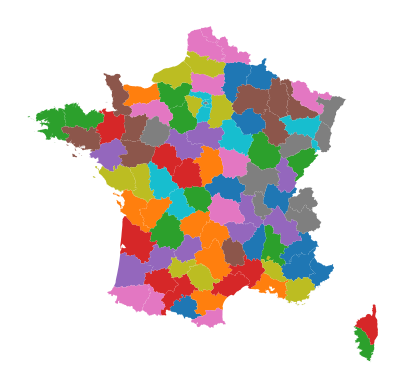

In [82]:
ax = dep.plot(column = "code_departement")
ax.set_axis_off()

## Agrégation des autres variables (températures minimales et maximales)

Nous allons considérer que la température minimale/maximale observée avant 22h est la température minimale/maximale de la journée.

Crérons une base des températures minimales
On extrait le base de données pour chaque 22h

In [88]:
base_22h=base_meteo_modifie_2[base_meteo_modifie_2['heure']=='22:00:00']
agregation_reg_min_max=base_22h.groupby(['jour','code_region'], as_index=False).agg({'temperature_celcius_min_sur_24h': 'min', 'temperature_celcius_max_sur_24h': 'max'})
agregation_reg_min_max = agregation_reg_min_max.rename(columns={'jour':'jour','code_region':'code_region','temperature_celcius_min_sur_24h':'temperature_celcius_min_sur_24h_region','temperature_celcius_max_sur_24h':'temperature_celcius_max_sur_24h_region'})

In [100]:
base_meteo_modifie_1.isna().sum()

num_station                              0
date_UTC                                 0
vitesse_vent                         26924
temperature                          15274
nebulosite_totale                  1203829
temperature_degre_celcius            15274
temperature_celcius_min_sur_24h    2143006
temperature_celcius_max_sur_24h    2143902
latitude                                 0
longitude                                0
altitude                                 0
libelle_geolocalisation             242657
nom_departement                     242657
code_departement                    242657
nom_region                          242657
code_region                         242657
mois                                     0
visibilite_horizontale              547882
coordonnees                              0
nom_commune                              0
jour                                     0
heure                                    0
dtype: int64

In [107]:
base_meteo_modifie_1['code_departement'].fillna(base_meteo_modifie_1.groupby('nom_commune')['code_departement'].transform(lambda x: x.mode().iloc[0]), inplace=True)

IndexError: single positional indexer is out-of-bounds

Fusion de la base agrégée obtenue et de la base de départ dans une nouvelle base

In [178]:
base_meteo_modifie_6 = pd.merge(base_meteo_modifie_5, agregation_reg_min_max, on=['jour','code_region'], how='left')

Aperçu

In [181]:
base_meteo_modifie_6.head()

,num_station,date_UTC,pression_mer,variation_pression_3h,type_tendance_baro,direction_vent,vitesse_vent,temperature,point_de_rosee,humidite,...,vitesse_vent_departement,nebulosite_totale_departement,visibilite_horizontale_departement,superficie_km2,temperature_degre_celcius_region,vitesse_vent_region,nebulosite_totale_region,visibilite_horizontale_region,temperature_celcius_min_sur_24h_region,temperature_celcius_max_sur_24h_region
0,7558,2010-01-05T10:00:00+01:00,100280.0,-50.0,5.0,260.0,1.5,275.75,275.75,100.0,...,1.5,100.0,4000.0,8735.1,4.108036,2.090036,NaN,NaN,NaN,NaN
1,61976,2010-01-05T10:00:00+01:00,100990.0,NaN,NaN,NaN,NaN,305.45,299.05,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7027,2010-01-05T13:00:00+01:00,100720.0,-190.0,8.0,200.0,3.6,273.65,271.75,87.0,...,3.1,67.5,16000.0,5534.5,0.340072,4.891300,77.822977,13389.512450,NaN,NaN
3,7110,2010-01-05T13:00:00+01:00,100750.0,-230.0,8.0,210.0,4.1,276.95,272.55,73.0,...,4.6,82.5,17000.0,6733,1.079720,3.376568,NaN,19629.335109,NaN,NaN
4,7591,2010-01-05T13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,274.45,269.05,67.0,...,NaN,NaN,NaN,5548.7,3.111914,NaN,NaN,NaN,NaN,NaN


In [50]:
base_meteo_modifie_2['jour'] = pd.to_datetime(base_meteo_modifie_2['jour'])
base_meteo_modifie_2.set_index('jour', inplace=True)
base_meteo_modifie_2 = base_meteo_modifie_2[base_meteo_modifie_2.index.year == annee_choisie]

Imputation des variables manquantes : KNN Imputer

On se dit que les zones ayant des données semblables météorologiques "se ressemblent"

On vérifie d'abord que toutes les variables sont numériques; 

In [ ]:
# Cas des données de consommation
data_consumption.dtypes

# Cas des données des communes
data_communes.dtypes


On convertit les colonnes

In [ ]:
cols = []
for col in cols:
    df[col] = df[col].astype(float)


On applique ensuite le KNN imputer

In [ ]:

# Initialiser l'imputeur KNN
cons_imputer = KNNImputer(n_neighbors=2)
com_imputer = KNNImputer(n_neighbors=2)

# Appliquer l'imputation
data_consumption_imputed = pd.DataFrame(cons_imputer.fit_transform(data_consumption), columns=data_consumption.columns)
data_communes_imputed = pd.DataFrame(com_imputer.fit_transform(data_communes), columns = data_communes.columns)


### Traitement de la base geographique pour le calcul des surfaces